# PREDICCION DE FASE USANDO NPL

## 1. Preparacion

### 1.1 Importe De Librerias

In [59]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from pylab import *
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
from scipy import stats
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from statistics import mean

import re
import nltk
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package stopwords to C:\Users\Diego
[nltk_data]     Ojeda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1.2 Carga de Base De Datos

In [26]:
path='Data.xlsx'
data=pd.read_excel(path)
data

,Siglas,Nombre,Desde,Hasta,MD From (ft),MD to (ft),Codigo,Subcodigo,Operación
0,ODR,MOR BL 04,2011-05-25 08:00:00,2011-05-25 11:00:00,2773.0,2773.0,1300,1304.0,"HANG TBG ON 7 1/16"" CASING HEAD. DISCONNECTED ..."
1,ODR,MOR BL 04,2011-05-25 02:30:00,2011-05-25 08:00:00,2773.0,2773.0,1100,1117.0,"RIH 2 7 /8"" TUBING EUE (31.62 FT) + NIPLESILL..."
2,ODR,MOR BL 04,2011-05-25 00:00:00,2011-05-25 02:30:00,2773.0,2773.0,1100,1116.0,CONTD. POOH AND L/D 3 1/2'' DP + SETTING TOOL ...
3,ODR,MOR BL 04,2011-05-24 00:00:00,2011-05-24 03:30:00,2773.0,2773.0,1500,1503.0,"GRAVEL PACKING 5½"" LINER W/ 10-16 MESH GRAVEL ..."
4,ODR,MOR BL 04,2011-05-24 21:30:00,2011-05-24 22:30:00,2773.0,2773.0,1500,1503.0,CONDITIONED BRINE TO 9.5 PPG AND CIRCULATED AN...
...,...,...,...,...,...,...,...,...,...
27180,ODR,MOR D 02,2009-08-22 17:30:00,2009-08-22 19:00:00,2907.0,2907.0,1500,1503.0,CONDITIONED BRINE TO PERFORM CEMENT JOB
27181,ODR,MOR D 02,2009-08-22 10:00:00,2009-08-22 10:30:00,2907.0,2907.0,1700,1701.0,HELD PREOPERATIONAL METTING TO SET PACKER STAG...
27182,ODR,MOR D 02,2009-08-23 00:00:00,2009-08-23 03:30:00,2907.0,2907.0,2100,2104.0,"HELD PREOPERATIONAL MEETING TO 7"" CASING CEMEN..."
27183,ODR,MOR D 02,2009-08-23 03:30:00,2009-08-24 00:00:00,2907.0,2907.0,2100,2106.0,"7""CSG CEMENT WOC"


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27185 entries, 0 to 27184
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Siglas        27185 non-null  object        
 1   Nombre        27185 non-null  object        
 2   Desde         27184 non-null  datetime64[ns]
 3   Hasta         27184 non-null  datetime64[ns]
 4   MD From (ft)  26180 non-null  float64       
 5   MD to (ft)    26162 non-null  float64       
 6   Codigo        27185 non-null  object        
 7   Subcodigo     26936 non-null  float64       
 8   Operación     27180 non-null  object        
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 1.9+ MB


### 1.3 Limpieza Y Organizacion De Base De Datos

In [28]:
# Eliminación de filas con datos nulos
data = data.dropna()
data = data.reset_index(drop=True)

# Funcion para calcular diferencias de dos fechas
def date_diff(date1, date2):
    return (date1 -  date2).total_seconds()/60/60

# Creacion de columna con la duracion de la actividad
data["Duracion"] = [date_diff(data.Hasta[i],data.Desde[i]) for i in range(len(data))]

# Funcion para caclular al media entre dos profundidades
def MD_Mean(MD_F,MD_T):
    return mean([MD_T,MD_F])

# Creacion de columna con la media de la profundidad en la actividad
data["MD_Mean"] = [MD_Mean(data["MD to (ft)"][i],data["MD From (ft)"][i]) for i in range(len(data))]

# Cambio de tipo de datos de las columnas
data['Subcodigo'] = data['Subcodigo'].astype(np.int64)
data['Codigo'] = data['Codigo'].astype(np.int64)

In [29]:
data

,Siglas,Nombre,Desde,Hasta,MD From (ft),MD to (ft),Codigo,Subcodigo,Operación,Duracion,MD_Mean
0,ODR,MOR BL 04,2011-05-25 08:00:00,2011-05-25 11:00:00,2773.0,2773.0,1300,1304,"HANG TBG ON 7 1/16"" CASING HEAD. DISCONNECTED ...",3.0,2773.0
1,ODR,MOR BL 04,2011-05-25 02:30:00,2011-05-25 08:00:00,2773.0,2773.0,1100,1117,"RIH 2 7 /8"" TUBING EUE (31.62 FT) + NIPLESILL...",5.5,2773.0
2,ODR,MOR BL 04,2011-05-25 00:00:00,2011-05-25 02:30:00,2773.0,2773.0,1100,1116,CONTD. POOH AND L/D 3 1/2'' DP + SETTING TOOL ...,2.5,2773.0
3,ODR,MOR BL 04,2011-05-24 00:00:00,2011-05-24 03:30:00,2773.0,2773.0,1500,1503,"GRAVEL PACKING 5½"" LINER W/ 10-16 MESH GRAVEL ...",3.5,2773.0
4,ODR,MOR BL 04,2011-05-24 21:30:00,2011-05-24 22:30:00,2773.0,2773.0,1500,1503,CONDITIONED BRINE TO 9.5 PPG AND CIRCULATED AN...,1.0,2773.0
...,...,...,...,...,...,...,...,...,...,...,...
25915,ODR,MOR D 02,2009-08-22 11:00:00,2009-08-22 13:00:00,2907.0,2907.0,2100,2104,PERFORM PRESURE LINE TEST W 4000 PSI. PUMPED...,2.0,2907.0
25916,ODR,MOR D 02,2009-08-22 17:30:00,2009-08-22 19:00:00,2907.0,2907.0,1500,1503,CONDITIONED BRINE TO PERFORM CEMENT JOB,1.5,2907.0
25917,ODR,MOR D 02,2009-08-22 10:00:00,2009-08-22 10:30:00,2907.0,2907.0,1700,1701,HELD PREOPERATIONAL METTING TO SET PACKER STAG...,0.5,2907.0
25918,ODR,MOR D 02,2009-08-23 00:00:00,2009-08-23 03:30:00,2907.0,2907.0,2100,2104,"HELD PREOPERATIONAL MEETING TO 7"" CASING CEMEN...",3.5,2907.0


In [30]:
# Eliminacion de columnas innecesarias y cambio de nombre de columnas
data = data.drop(['Desde', 'Hasta',"MD From (ft)","MD to (ft)","Nombre"], axis=1)
data = data.rename({'Operación':"Operacion"}, axis=1)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920 entries, 0 to 25919
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Siglas     25920 non-null  object 
 1   Codigo     25920 non-null  int64  
 2   Subcodigo  25920 non-null  int64  
 3   Operacion  25920 non-null  object 
 4   Duracion   25920 non-null  float64
 5   MD_Mean    25920 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.2+ MB


In [32]:
data

,Siglas,Codigo,Subcodigo,Operacion,Duracion,MD_Mean
0,ODR,1300,1304,"HANG TBG ON 7 1/16"" CASING HEAD. DISCONNECTED ...",3.0,2773.0
1,ODR,1100,1117,"RIH 2 7 /8"" TUBING EUE (31.62 FT) + NIPLESILL...",5.5,2773.0
2,ODR,1100,1116,CONTD. POOH AND L/D 3 1/2'' DP + SETTING TOOL ...,2.5,2773.0
3,ODR,1500,1503,"GRAVEL PACKING 5½"" LINER W/ 10-16 MESH GRAVEL ...",3.5,2773.0
4,ODR,1500,1503,CONDITIONED BRINE TO 9.5 PPG AND CIRCULATED AN...,1.0,2773.0
...,...,...,...,...,...,...
25915,ODR,2100,2104,PERFORM PRESURE LINE TEST W 4000 PSI. PUMPED...,2.0,2907.0
25916,ODR,1500,1503,CONDITIONED BRINE TO PERFORM CEMENT JOB,1.5,2907.0
25917,ODR,1700,1701,HELD PREOPERATIONAL METTING TO SET PACKER STAG...,0.5,2907.0
25918,ODR,2100,2104,"HELD PREOPERATIONAL MEETING TO 7"" CASING CEMEN...",3.5,2907.0


## 2. Preprocesamiento Para NPL

### 2.1 Selección De Los Datos y El Target

In [33]:
y = data.Siglas
X = data.Operacion

### 2.2 Codificacion y Remocion De Caracteres Especiales, Lematizacion y Minúsculas

In [34]:
# Codificacion Del Target
le = preprocessing.LabelEncoder()
le.fit(["ODR", "OCM"])
y = le.transform(y)

LabelEncoder()

In [35]:
documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):

    # Removemos los caracteres especiales
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # Removemos todos las cadenas de caracteres de un solo caracter
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Removemos caracteres sencillso al inicio
    # document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituimos dobles espacios por espacios sencillos
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Convertimos todo a minusculas
    document = document.lower()
    
    # Realizamos Lematizacion
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

### 2.3 Realizamos Vectorizacion

In [36]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

### 2.4 Realizamos Calcuos de TF-I-DF

In [37]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

## 3. Pruebas De Modelos

### 3.1 Division Entre Train & Test

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 3.2 XGBoost

In [39]:
import xgboost as xgb

classifier = xgb.XGBRFClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

C:\Users\Diego Ojeda\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=1000, n_jobs=8,
                num_parallel_tree=1000, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [49]:
y_pred = classifier.predict(X_test)

In [50]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [51]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  72  151]
 [  28 4933]]
              precision    recall  f1-score   support

           0       0.72      0.32      0.45       223
           1       0.97      0.99      0.98      4961

    accuracy                           0.97      5184
   macro avg       0.85      0.66      0.71      5184
weighted avg       0.96      0.97      0.96      5184

0.9654706790123457


In [43]:
from sklearn.model_selection import RandomizedSearchCV

# Definimos los interevalos de parámetros a utilizar
#---------------------------------------------------

# Numero de arboles del modelo
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000,num=10)]

learning_rate =  [0.001,0.01, 0.1, 0.5]

# Numero de variables a considerar en cada division del arbol
max_features = ["auto","sqrt"]

# Maximo numero de niveles (profundidad) en cada arbol
max_depth = [int(x) for x in np.linspace(10,100, num = 11)]
max_depth.append(None)


# Creamos la grilla aleatoria
random_grid = {"n_estimators":n_estimators,
               "learning_rate":learning_rate,
               "max_features": max_features,
               "max_depth":max_depth,
                }

In [53]:
# Entrenaremos un modelo a traves de la malla de busqueda
#--------------------------------------------------------

# Instanciamos el modelo
import xgboost as xgb
classifier = xgb.XGBRFClassifier()

# Creamos el modelo usando RandomSearchCV
xgb_random = RandomizedSearchCV(estimator=classifier,
                               param_distributions=random_grid,
                               n_iter=10,
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1
                                )

xgb_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Diego Ojeda\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:07:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBRFClassifier(base_score=None, booster=None,
                                             colsample_bylevel=None,
                                             colsample_bytree=None,
                                             enable_categorical=False,
                                             gamma=None, gpu_id=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             max_delta_step=None,
                                             max_depth=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             n_estimators=100, n_jobs=None,
                                             num_...
                                             predictor=None, random_st

In [54]:
# Veremos los parámetros que dieron el mejor resultado
xgb_random.best_params_

{'n_estimators': 400,
 'max_features': 'auto',
 'max_depth': 19,
 'learning_rate': 0.01}

In [55]:
xgb_random.best_score_

0.9700038580246914

In [56]:
y_pred = xgb_random.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [57]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 103  120]
 [  53 4908]]
              precision    recall  f1-score   support

           0       0.66      0.46      0.54       223
           1       0.98      0.99      0.98      4961

    accuracy                           0.97      5184
   macro avg       0.82      0.73      0.76      5184
weighted avg       0.96      0.97      0.96      5184

0.9666280864197531


C:\Users\Diego Ojeda\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


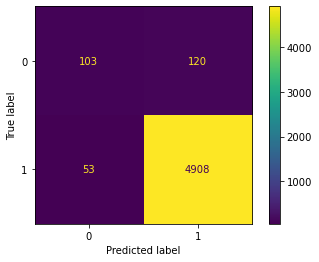

In [60]:
plot_confusion_matrix(xgb_random, X_test, y_test)

C:\Users\Diego Ojeda\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


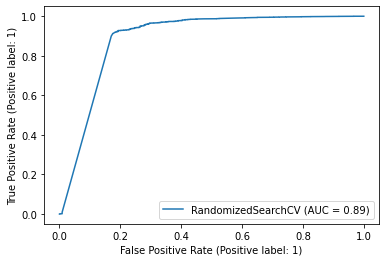

In [61]:
from sklearn import metrics
metrics.plot_roc_curve(xgb_random, X_test, y_test)